# MNIST GAN Implementation

This notebook implements a Generative Adversarial Network (GAN) trained on the MNIST dataset using PyTorch. This serves as the foundation for investigating whether informative data samples exist for GAN training, similar to those found in supervised learning.

## Thesis Context
Recent research has shown that state-of-the-art machine learning models can be trained effectively using only specific subsets of training data. These "informative samples" enhance generalization in neural networks. While this phenomenon has been observed in supervised learning, this project aims to investigate whether similar informative samples exist when training generative models like GANs.

## Notebook Overview
1. **Setup and Imports**: Libraries and device configuration
2. **Hyperparameters**: Configuration for the GAN training
3. **Model Architecture**: Implementation of Generator and Discriminator networks
4. **Data Loading**: MNIST dataset preparation
5. **Visualization Functions**: Utilities for tracking GAN performance
6. **Training Loop**: Implementation of the GAN training process
7. **Execution and Results**: Running the training and analyzing outputs

## 1. Setup and Imports

First, we'll import the necessary libraries and set up the computational device (CPU or GPU).

In [191]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os
import time
import random

# Set random seed for reproducibility
def set_random_seed(seed):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Hyperparameters

Here we define all the hyperparameters that control the GAN training process. These include:

- Batch size: Number of images processed in each training step
- Latent dimension: Size of the random noise vector input to the generator
- Hidden dimensions: Size of hidden layers in the networks
- Learning rates and optimizer parameters
- Training duration and image sampling frequency

In [192]:
# Hyperparameters
batch_size = 128
latent_dim = 128     # Size of generator input noise vector
hidden_dim = 256     # Size of hidden layers
image_size = 28 * 28 # MNIST image dimensions flattened
lr = 0.0002          # Learning rate
beta1 = 0.5          # Adam optimizer beta1
beta2 = 0.999        # Adam optimizer beta2
num_epochs = 100     # Number of training epochs
sample_interval = 10 # Save images every 10 epochs

## 3. Model Architecture

### Generator Network

The Generator transforms random noise vectors into synthetic images. Its architecture consists of:
- Input: Random noise vector (latent_dim)
- Multiple fully connected layers with LeakyReLU activations
- Output: Image with values in range [-1, 1] through Tanh activation

This implementation uses a simple MLP (Multi-Layer Perceptron) architecture rather than convolutional layers for simplicity.

In [193]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to image dimensions
        return img

### Discriminator Network

The Discriminator evaluates whether an image is real (from the dataset) or fake (generated). Its architecture consists of:
- Input: Flattened image (28×28 = 784 dimensions)
- Multiple fully connected layers with LeakyReLU activations and dropout for regularization
- Output: Single value between 0-1 through Sigmoid activation (probability of image being real)

In [194]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0-1 (probability of being real)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)
        return validity

### Initialize Models and Optimizers

Here we:
1. Initialize both networks
2. Define the loss function (Binary Cross Entropy)
3. Set up optimizers for both networks

In [195]:
# Initialize models
generator = Generator(latent_dim, hidden_dim, image_size).to(device)
discriminator = Discriminator(image_size, hidden_dim).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## 4. Data Loading

Here we set up the MNIST dataset with appropriate transformations:
- ToTensor: Converts PIL images to PyTorch tensors
- Normalize: Scales pixel values from [0,1] to [-1,1] to match the Generator's Tanh output

In [196]:
set_random_seed(42)

def load_data(subset_percentage=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    full_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    all_targets = full_dataset.targets.numpy()
    
    digit_counts = [0] * 10
    for label in all_targets:
        digit_counts[label] += 1
    
    print("Full dataset distribution:")
    for digit, count in enumerate(digit_counts):
        print(f"Digit {digit}: {count} samples")
    
    if subset_percentage == 100:
        selected_dataset = full_dataset
    else:
        digit_indices = [[] for _ in range(10)]
        
        for idx, label in enumerate(all_targets):
            digit_indices[label].append(idx)
        
        total_subset_size = int(len(full_dataset) * subset_percentage / 100)
        samples_per_digit = total_subset_size // 10
        
        stratified_indices = []
        for digit in range(10):
            digit_idx = digit_indices[digit]
            random_idx = torch.randperm(len(digit_idx))

            selected_idx = [digit_idx[i] for i in random_idx[:samples_per_digit]]
            stratified_indices.extend(selected_idx)
        print(all_targets[stratified_indices])
        random.shuffle(stratified_indices)
        print(all_targets[stratified_indices])
        selected_dataset = torch.utils.data.Subset(full_dataset, stratified_indices)
        
        subset_digit_counts = [0] * 10
        for idx in stratified_indices:
            label = all_targets[idx]
            subset_digit_counts[label] += 1
        
        print("\nStratified subset distribution:")
        for digit, count in enumerate(subset_digit_counts):
            print(f"Digit {digit}: {count} samples")
    
    data_loader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # Discard incomplete batches
    )
    
    print(f"\nFull dataset size: {len(full_dataset)} images")
    print(f"Selected subset size: {len(selected_dataset)} images")
    print(f"Number of batches: {len(data_loader)}")
    
    return data_loader, selected_dataset

In [197]:
set_random_seed(42)

subset_percentage = 90
train_loader, train_dataset = load_data(subset_percentage)

Full dataset distribution:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples
[0 0 0 ... 9 9 9]
[2 6 5 ... 0 1 7]

Stratified subset distribution:
Digit 0: 5400 samples
Digit 1: 5400 samples
Digit 2: 5400 samples
Digit 3: 5400 samples
Digit 4: 5400 samples
Digit 5: 5400 samples
Digit 6: 5400 samples
Digit 7: 5400 samples
Digit 8: 5400 samples
Digit 9: 5400 samples

Full dataset size: 60000 images
Selected subset size: 54000 images
Number of batches: 421


## 5. Visualization Functions

These utility functions help monitor the GAN's progress:

1. `save_generated_images`: Creates and saves a grid of generated images
2. `plot_losses`: Visualizes generator and discriminator losses over time

In [198]:
def save_generated_images(epoch, generator, latent_dim, device, subset_percentage, 
                         fixed_noise=None, base_path="../generated_images"):
    
    subfolder = f"subset_{subset_percentage}_percent"
    save_path = os.path.join(base_path, subfolder)
    os.makedirs(save_path, exist_ok=True)
    
    # Create a batch of latent vectors or use fixed noise for comparison
    if fixed_noise is None:
        z = torch.randn(25, latent_dim).to(device)
    else:
        z = fixed_noise
    
    # Generate images
    with torch.no_grad():
        gen_imgs = generator(z).detach().cpu()
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    grid = make_grid(gen_imgs, nrow=5, normalize=True)
    
    filename = f"epoch_{epoch:03d}.png"
    filepath = os.path.join(save_path, filename)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Images - {subset_percentage}% Data - Epoch {epoch}")

    plt.savefig(filepath)
    plt.show()
    
    return grid

In [199]:
def plot_losses(g_losses, d_losses, subset_percentage, save_path="../loss_plots"):
    # Create folder structure
    os.makedirs(save_path, exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title(f'GAN Training Losses - {subset_percentage}% Data')
    
    plt.savefig(f"{save_path}/losses_subset_{subset_percentage}_percent.png")
    plt.show()

## 6. Training Loop

The GAN training function implements the adversarial training process with these key steps:

1. **Initialization**:
   - Create fixed noise vector for consistent image generation across epochs
   - Initialize lists to track losses

2. **For each epoch and batch**:
   - **Train Discriminator**:
     - Forward pass with real images → calculate loss on real images
     - Generate fake images → calculate loss on fake images
     - Update discriminator weights
   - **Train Generator**:
     - Generate fake images
     - Calculate loss based on discriminator's prediction
     - Update generator weights

3. **Monitoring**:
   - Save losses for plotting
   - Generate and save images at regular intervals
   - Track and display progress information

In [200]:
def train_gan(subset_percentage=100):
    # Generate fixed noise for consistent image generation
    fixed_noise = torch.randn(25, latent_dim).to(device)
    
    # Create lists to store losses
    g_losses = []
    d_losses = []
    start_time = time.time()
    
    print("Starting Training...")
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        batch_count = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_count += 1
            
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Create labels with a small amount of label smoothing
            valid = torch.ones(batch_size, 1).to(device) * 0.9
            fake = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Loss on real images
            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)
            
            # Sample noise and generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Loss on fake images
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()
            
            # Generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Try to fool the discriminator
            validity = discriminator(fake_imgs)
            g_loss = adversarial_loss(validity, valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            # Save losses for plotting
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                      f"[Time: {time.time() - start_time:.2f}s]")
        
        # Calculate and store average losses for this epoch
        g_losses.append(g_loss_epoch / batch_count)
        d_losses.append(d_loss_epoch / batch_count)
        
        # Print epoch summary
        print(f"[Epoch {epoch}/{num_epochs}] "
              f"[Avg D loss: {d_losses[-1]:.4f}] [Avg G loss: {g_losses[-1]:.4f}]")

        
        # Save generated images at specified intervals
        if epoch % sample_interval == 0 or epoch == num_epochs - 1:
            _ = save_generated_images(epoch, generator, latent_dim, device, subset_percentage, fixed_noise)
            
        # Plot losses at each epoch
        if epoch % 10 == 0:
            plot_losses(g_losses, d_losses, subset_percentage)
    
    plot_losses(g_losses, d_losses, subset_percentage)
    
    print("Training finished!")
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    
    # Also update the model saving to include subset percentage
    model_path = f"../models/subset_{subset_percentage}_percent"
    os.makedirs(model_path, exist_ok=True)
    torch.save(generator.state_dict(), f'{model_path}/generator.pth')
    torch.save(discriminator.state_dict(), f'{model_path}/discriminator.pth')
    
    print("Models saved!")
    
    return g_losses, d_losses

## 7. Execution and Results

Now we'll run the training function and analyze the results.

Starting Training...
[Epoch 0/100] [Batch 0/421] [D loss: 1.3762] [G loss: 0.6714] [Time: 0.07s]
[Epoch 0/100] [Batch 100/421] [D loss: 1.1914] [G loss: 1.0742] [Time: 5.82s]
[Epoch 0/100] [Batch 200/421] [D loss: 1.1086] [G loss: 0.9641] [Time: 11.41s]
[Epoch 0/100] [Batch 300/421] [D loss: 0.7351] [G loss: 1.8413] [Time: 16.71s]
[Epoch 0/100] [Batch 400/421] [D loss: 0.7856] [G loss: 2.2660] [Time: 22.37s]
[Epoch 0/100] [Avg D loss: 1.0277] [Avg G loss: 1.5116]


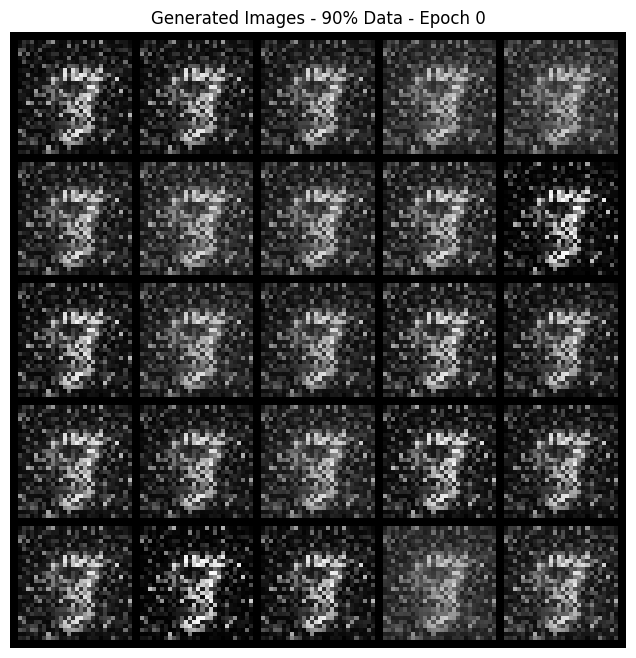

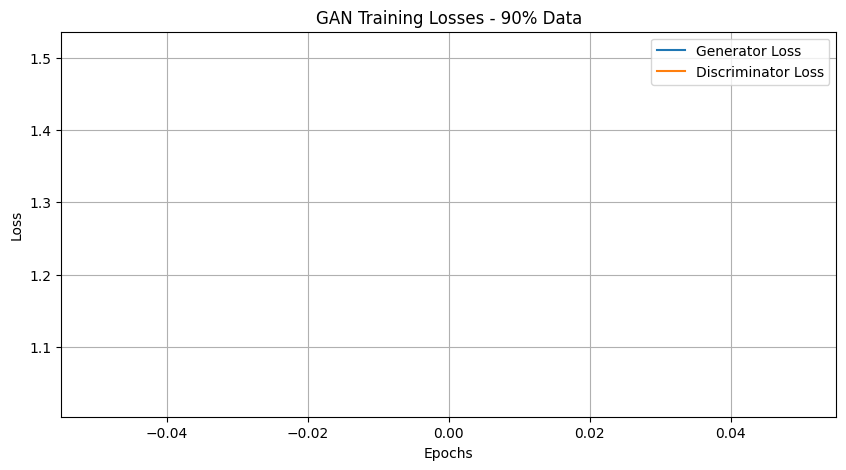

[Epoch 1/100] [Batch 0/421] [D loss: 0.7945] [G loss: 2.3476] [Time: 23.88s]
[Epoch 1/100] [Batch 100/421] [D loss: 0.7779] [G loss: 1.6702] [Time: 29.19s]
[Epoch 1/100] [Batch 200/421] [D loss: 0.9767] [G loss: 3.5980] [Time: 34.52s]
[Epoch 1/100] [Batch 300/421] [D loss: 0.7464] [G loss: 2.2313] [Time: 39.90s]
[Epoch 1/100] [Batch 400/421] [D loss: 0.7260] [G loss: 2.0887] [Time: 45.26s]
[Epoch 1/100] [Avg D loss: 0.8758] [Avg G loss: 2.2499]
[Epoch 2/100] [Batch 0/421] [D loss: 0.7784] [G loss: 2.4558] [Time: 46.40s]
[Epoch 2/100] [Batch 100/421] [D loss: 0.7372] [G loss: 2.2387] [Time: 51.89s]
[Epoch 2/100] [Batch 200/421] [D loss: 1.6985] [G loss: 1.0083] [Time: 57.25s]
[Epoch 2/100] [Batch 300/421] [D loss: 1.1211] [G loss: 1.3053] [Time: 62.60s]
[Epoch 2/100] [Batch 400/421] [D loss: 1.0206] [G loss: 1.6649] [Time: 67.91s]
[Epoch 2/100] [Avg D loss: 0.8821] [Avg G loss: 2.0987]
[Epoch 3/100] [Batch 0/421] [D loss: 0.8032] [G loss: 2.2629] [Time: 69.05s]
[Epoch 3/100] [Batch 100/

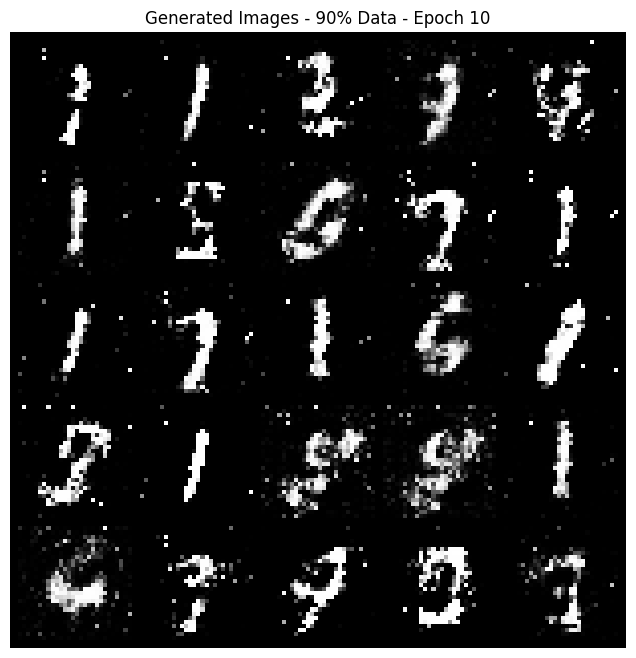

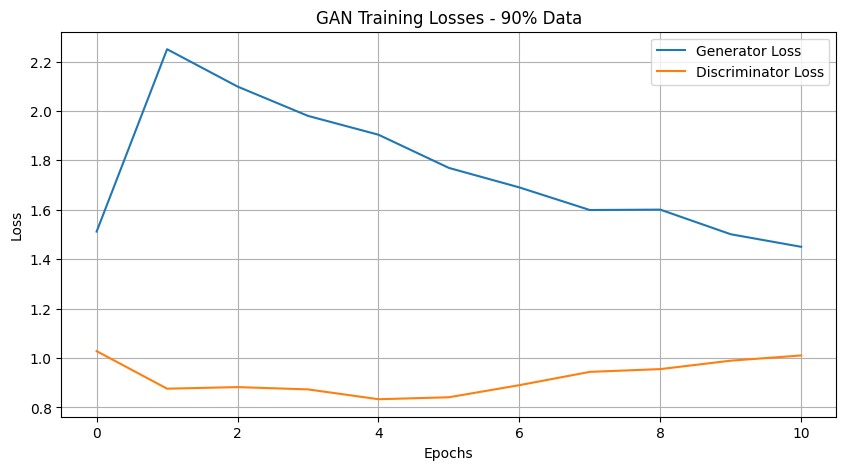

[Epoch 11/100] [Batch 0/421] [D loss: 1.0428] [G loss: 1.0781] [Time: 248.26s]
[Epoch 11/100] [Batch 100/421] [D loss: 1.0139] [G loss: 1.3269] [Time: 253.55s]
[Epoch 11/100] [Batch 200/421] [D loss: 1.0595] [G loss: 1.0699] [Time: 258.82s]
[Epoch 11/100] [Batch 300/421] [D loss: 1.0633] [G loss: 1.2386] [Time: 264.65s]
[Epoch 11/100] [Batch 400/421] [D loss: 1.0219] [G loss: 1.4136] [Time: 270.69s]
[Epoch 11/100] [Avg D loss: 1.0481] [Avg G loss: 1.3373]
[Epoch 12/100] [Batch 0/421] [D loss: 1.0405] [G loss: 1.1380] [Time: 271.94s]
[Epoch 12/100] [Batch 100/421] [D loss: 1.0071] [G loss: 1.2103] [Time: 277.66s]
[Epoch 12/100] [Batch 200/421] [D loss: 1.0467] [G loss: 1.1853] [Time: 283.24s]
[Epoch 12/100] [Batch 300/421] [D loss: 1.0567] [G loss: 2.0490] [Time: 288.67s]
[Epoch 12/100] [Batch 400/421] [D loss: 1.0395] [G loss: 1.2135] [Time: 294.05s]
[Epoch 12/100] [Avg D loss: 1.0408] [Avg G loss: 1.3415]
[Epoch 13/100] [Batch 0/421] [D loss: 1.0183] [G loss: 1.4883] [Time: 295.17s]
[

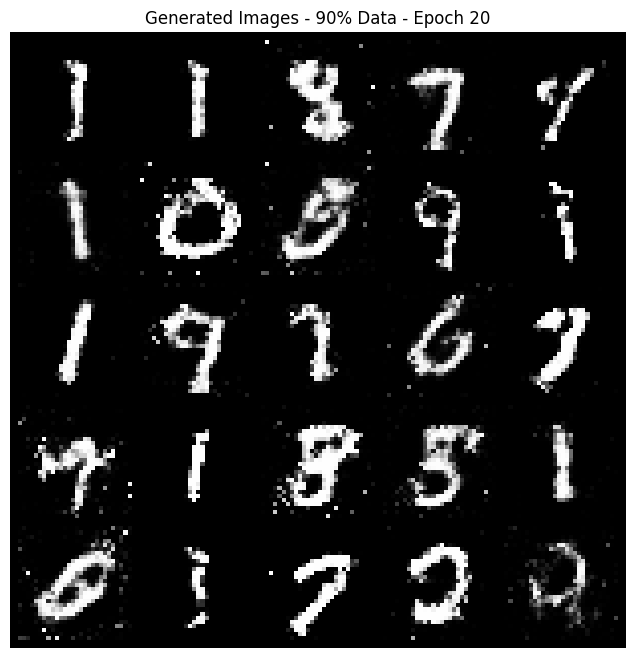

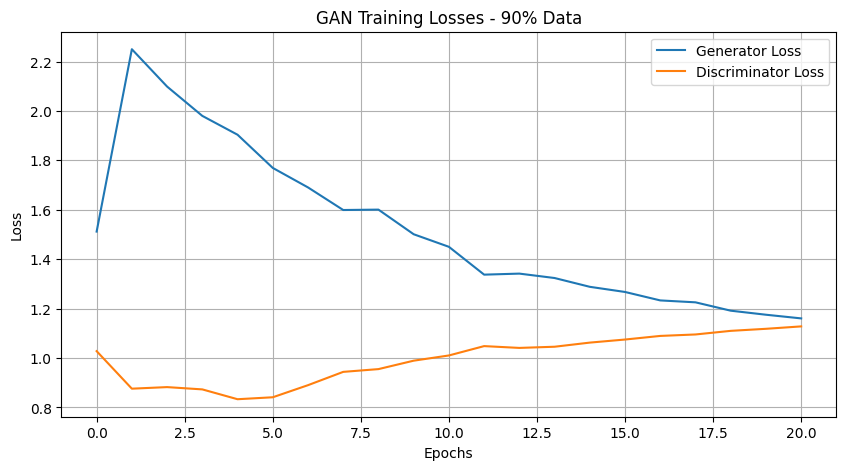

[Epoch 21/100] [Batch 0/421] [D loss: 1.1433] [G loss: 0.9174] [Time: 476.74s]
[Epoch 21/100] [Batch 100/421] [D loss: 1.0708] [G loss: 1.1759] [Time: 482.31s]
[Epoch 21/100] [Batch 200/421] [D loss: 1.1654] [G loss: 1.0780] [Time: 487.97s]
[Epoch 21/100] [Batch 300/421] [D loss: 1.1153] [G loss: 0.9939] [Time: 493.54s]
[Epoch 21/100] [Batch 400/421] [D loss: 1.1097] [G loss: 1.4333] [Time: 499.22s]
[Epoch 21/100] [Avg D loss: 1.1292] [Avg G loss: 1.1523]
[Epoch 22/100] [Batch 0/421] [D loss: 1.1146] [G loss: 1.1807] [Time: 500.36s]
[Epoch 22/100] [Batch 100/421] [D loss: 1.1233] [G loss: 1.0968] [Time: 505.73s]
[Epoch 22/100] [Batch 200/421] [D loss: 1.1258] [G loss: 1.1930] [Time: 511.10s]
[Epoch 22/100] [Batch 300/421] [D loss: 1.1768] [G loss: 1.0459] [Time: 516.47s]
[Epoch 22/100] [Batch 400/421] [D loss: 1.1155] [G loss: 0.8473] [Time: 521.81s]
[Epoch 22/100] [Avg D loss: 1.1367] [Avg G loss: 1.1397]
[Epoch 23/100] [Batch 0/421] [D loss: 1.1484] [G loss: 1.3116] [Time: 522.98s]
[

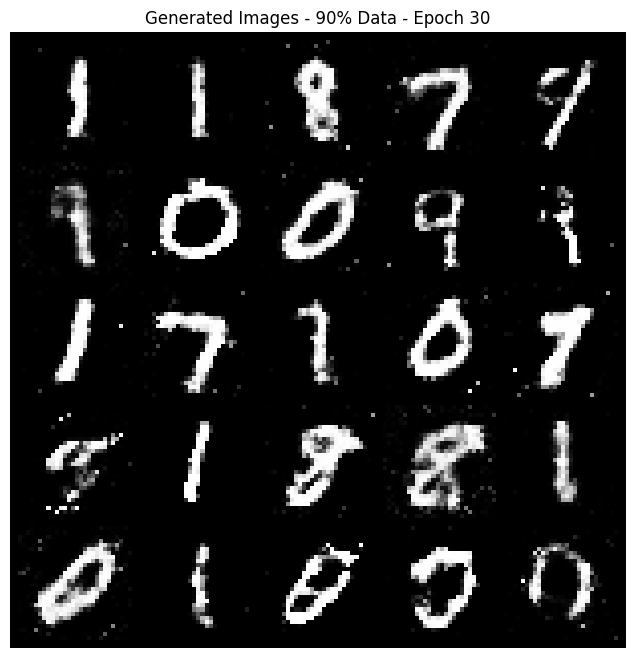

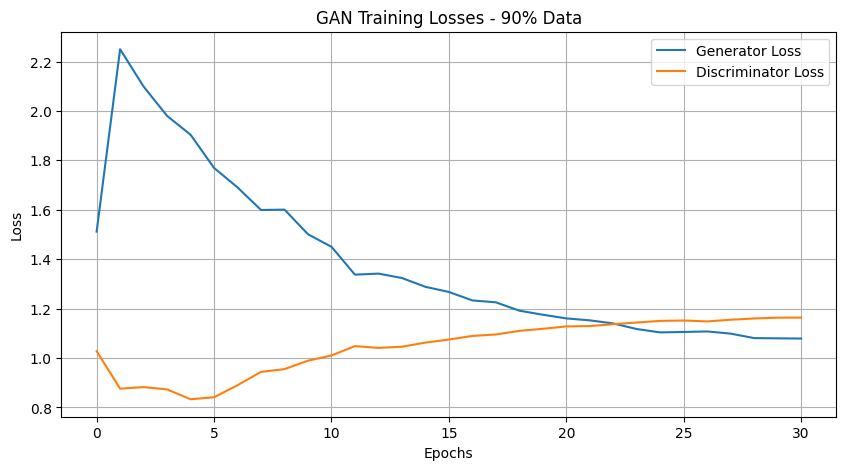

[Epoch 31/100] [Batch 0/421] [D loss: 1.1949] [G loss: 1.1134] [Time: 704.54s]
[Epoch 31/100] [Batch 100/421] [D loss: 1.1112] [G loss: 0.9381] [Time: 709.92s]
[Epoch 31/100] [Batch 200/421] [D loss: 1.1949] [G loss: 0.9532] [Time: 715.31s]
[Epoch 31/100] [Batch 300/421] [D loss: 1.1281] [G loss: 1.0678] [Time: 720.70s]
[Epoch 31/100] [Batch 400/421] [D loss: 1.1718] [G loss: 0.9876] [Time: 726.03s]
[Epoch 31/100] [Avg D loss: 1.1728] [Avg G loss: 1.0593]
[Epoch 32/100] [Batch 0/421] [D loss: 1.1952] [G loss: 1.0496] [Time: 727.18s]
[Epoch 32/100] [Batch 100/421] [D loss: 1.1228] [G loss: 0.9983] [Time: 732.58s]
[Epoch 32/100] [Batch 200/421] [D loss: 1.1256] [G loss: 1.0608] [Time: 738.00s]
[Epoch 32/100] [Batch 300/421] [D loss: 1.1301] [G loss: 1.0747] [Time: 743.36s]
[Epoch 32/100] [Batch 400/421] [D loss: 1.0938] [G loss: 1.1556] [Time: 748.70s]
[Epoch 32/100] [Avg D loss: 1.1774] [Avg G loss: 1.0636]
[Epoch 33/100] [Batch 0/421] [D loss: 1.2043] [G loss: 1.0548] [Time: 749.87s]
[

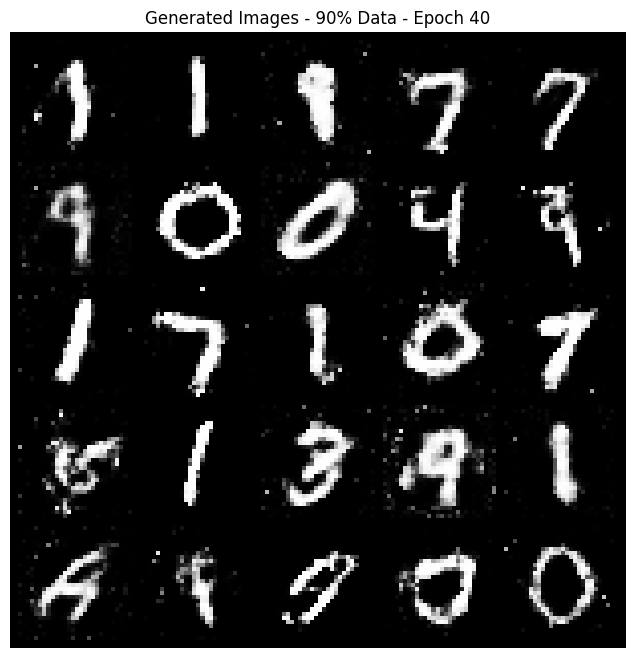

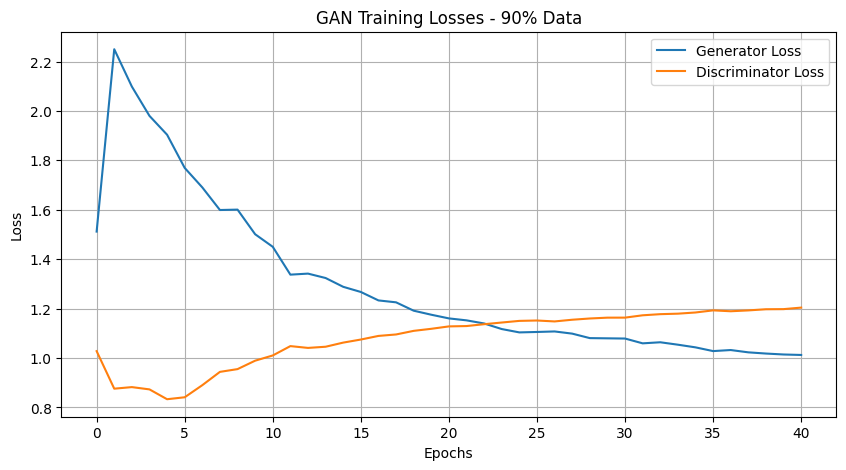

[Epoch 41/100] [Batch 0/421] [D loss: 1.1060] [G loss: 1.1854] [Time: 931.04s]
[Epoch 41/100] [Batch 100/421] [D loss: 1.1724] [G loss: 1.1599] [Time: 936.42s]
[Epoch 41/100] [Batch 200/421] [D loss: 1.3323] [G loss: 0.6924] [Time: 941.80s]
[Epoch 41/100] [Batch 300/421] [D loss: 1.1818] [G loss: 1.0884] [Time: 947.18s]
[Epoch 41/100] [Batch 400/421] [D loss: 1.2280] [G loss: 1.0751] [Time: 952.56s]
[Epoch 41/100] [Avg D loss: 1.2065] [Avg G loss: 1.0028]
[Epoch 42/100] [Batch 0/421] [D loss: 1.2239] [G loss: 0.8012] [Time: 953.71s]
[Epoch 42/100] [Batch 100/421] [D loss: 1.2216] [G loss: 0.9406] [Time: 959.09s]
[Epoch 42/100] [Batch 200/421] [D loss: 1.2343] [G loss: 0.9092] [Time: 964.43s]
[Epoch 42/100] [Batch 300/421] [D loss: 1.1577] [G loss: 1.0359] [Time: 969.83s]
[Epoch 42/100] [Batch 400/421] [D loss: 1.2159] [G loss: 0.7999] [Time: 975.23s]
[Epoch 42/100] [Avg D loss: 1.2092] [Avg G loss: 0.9969]
[Epoch 43/100] [Batch 0/421] [D loss: 1.1975] [G loss: 0.9903] [Time: 976.36s]
[

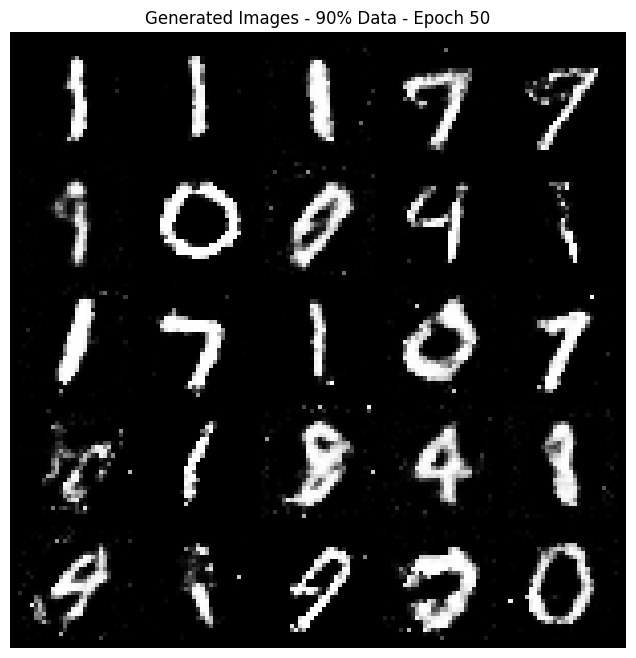

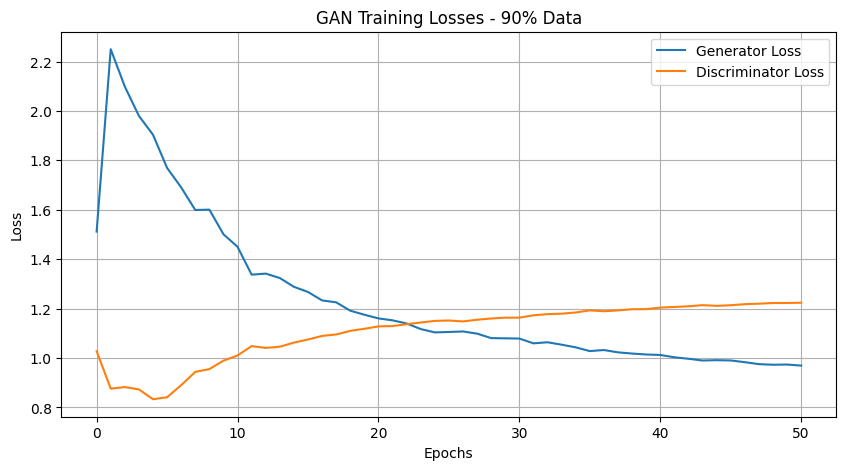

[Epoch 51/100] [Batch 0/421] [D loss: 1.1633] [G loss: 0.9815] [Time: 1157.63s]
[Epoch 51/100] [Batch 100/421] [D loss: 1.1990] [G loss: 1.0464] [Time: 1163.02s]
[Epoch 51/100] [Batch 200/421] [D loss: 1.1939] [G loss: 0.9947] [Time: 1168.36s]
[Epoch 51/100] [Batch 300/421] [D loss: 1.2446] [G loss: 0.8938] [Time: 1173.74s]
[Epoch 51/100] [Batch 400/421] [D loss: 1.2247] [G loss: 1.0296] [Time: 1179.06s]
[Epoch 51/100] [Avg D loss: 1.2243] [Avg G loss: 0.9702]
[Epoch 52/100] [Batch 0/421] [D loss: 1.2170] [G loss: 0.9028] [Time: 1180.19s]
[Epoch 52/100] [Batch 100/421] [D loss: 1.2541] [G loss: 0.9919] [Time: 1185.58s]
[Epoch 52/100] [Batch 200/421] [D loss: 1.2032] [G loss: 1.1308] [Time: 1190.94s]
[Epoch 52/100] [Batch 300/421] [D loss: 1.2122] [G loss: 1.1003] [Time: 1196.29s]
[Epoch 52/100] [Batch 400/421] [D loss: 1.2772] [G loss: 0.9256] [Time: 1201.69s]
[Epoch 52/100] [Avg D loss: 1.2270] [Avg G loss: 0.9625]
[Epoch 53/100] [Batch 0/421] [D loss: 1.1768] [G loss: 1.0053] [Time: 

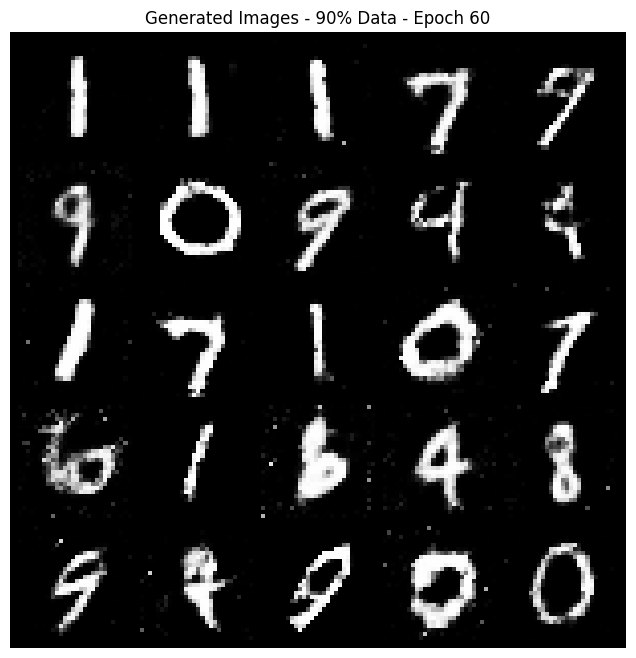

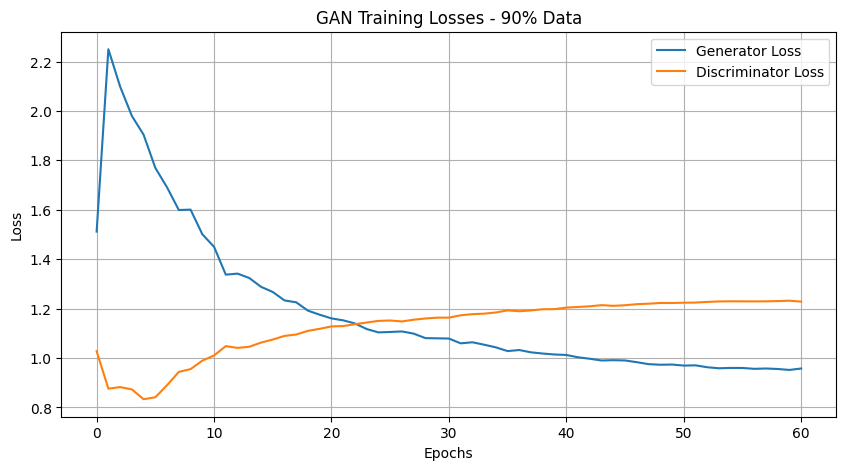

[Epoch 61/100] [Batch 0/421] [D loss: 1.1939] [G loss: 1.0981] [Time: 1384.17s]
[Epoch 61/100] [Batch 100/421] [D loss: 1.2437] [G loss: 1.0774] [Time: 1389.53s]
[Epoch 61/100] [Batch 200/421] [D loss: 1.2933] [G loss: 0.7780] [Time: 1394.93s]
[Epoch 61/100] [Batch 300/421] [D loss: 1.1550] [G loss: 0.9782] [Time: 1400.28s]
[Epoch 61/100] [Batch 400/421] [D loss: 1.2242] [G loss: 0.9687] [Time: 1405.65s]
[Epoch 61/100] [Avg D loss: 1.2334] [Avg G loss: 0.9499]
[Epoch 62/100] [Batch 0/421] [D loss: 1.2304] [G loss: 0.9806] [Time: 1406.77s]
[Epoch 62/100] [Batch 100/421] [D loss: 1.2111] [G loss: 0.9031] [Time: 1412.16s]
[Epoch 62/100] [Batch 200/421] [D loss: 1.2482] [G loss: 0.9129] [Time: 1417.50s]
[Epoch 62/100] [Batch 300/421] [D loss: 1.2210] [G loss: 0.9484] [Time: 1422.88s]
[Epoch 62/100] [Batch 400/421] [D loss: 1.2865] [G loss: 1.0732] [Time: 1428.25s]
[Epoch 62/100] [Avg D loss: 1.2345] [Avg G loss: 0.9476]
[Epoch 63/100] [Batch 0/421] [D loss: 1.2794] [G loss: 0.9849] [Time: 

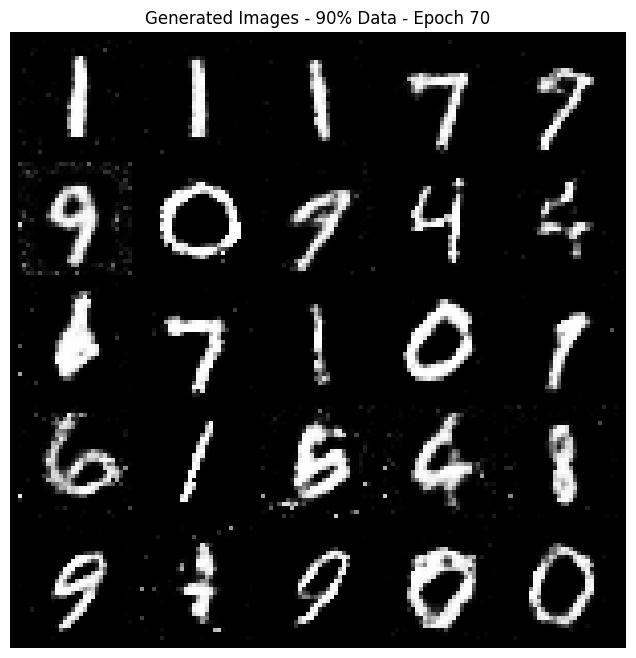

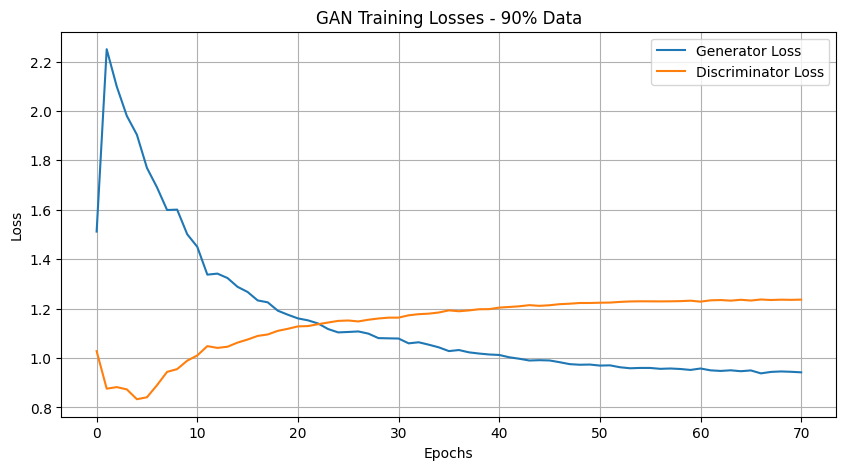

[Epoch 71/100] [Batch 0/421] [D loss: 1.2638] [G loss: 0.9317] [Time: 1611.07s]
[Epoch 71/100] [Batch 100/421] [D loss: 1.2041] [G loss: 0.9968] [Time: 1616.46s]
[Epoch 71/100] [Batch 200/421] [D loss: 1.2899] [G loss: 1.0054] [Time: 1621.85s]
[Epoch 71/100] [Batch 300/421] [D loss: 1.2313] [G loss: 1.0473] [Time: 1627.29s]
[Epoch 71/100] [Batch 400/421] [D loss: 1.2364] [G loss: 0.9913] [Time: 1632.67s]
[Epoch 71/100] [Avg D loss: 1.2364] [Avg G loss: 0.9384]
[Epoch 72/100] [Batch 0/421] [D loss: 1.2383] [G loss: 0.9723] [Time: 1633.84s]
[Epoch 72/100] [Batch 100/421] [D loss: 1.2191] [G loss: 0.9257] [Time: 1639.29s]
[Epoch 72/100] [Batch 200/421] [D loss: 1.2485] [G loss: 1.0257] [Time: 1644.65s]
[Epoch 72/100] [Batch 300/421] [D loss: 1.2311] [G loss: 0.8867] [Time: 1650.01s]
[Epoch 72/100] [Batch 400/421] [D loss: 1.2893] [G loss: 0.9669] [Time: 1655.42s]
[Epoch 72/100] [Avg D loss: 1.2361] [Avg G loss: 0.9395]
[Epoch 73/100] [Batch 0/421] [D loss: 1.2298] [G loss: 0.9193] [Time: 

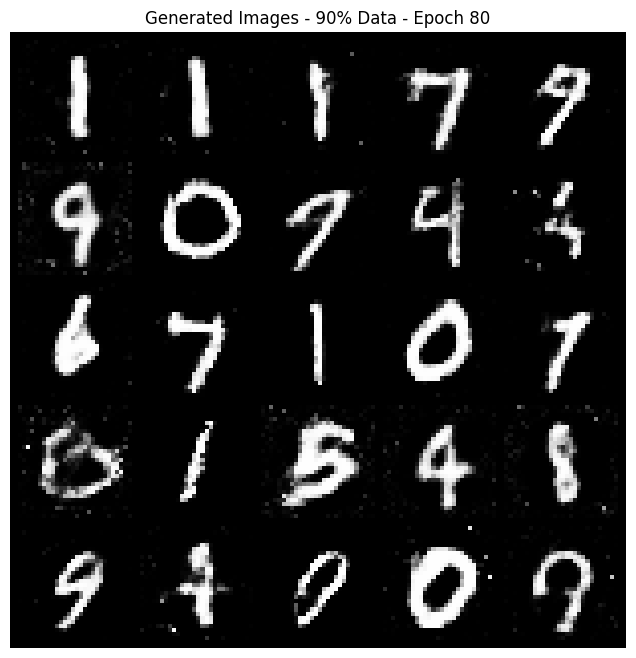

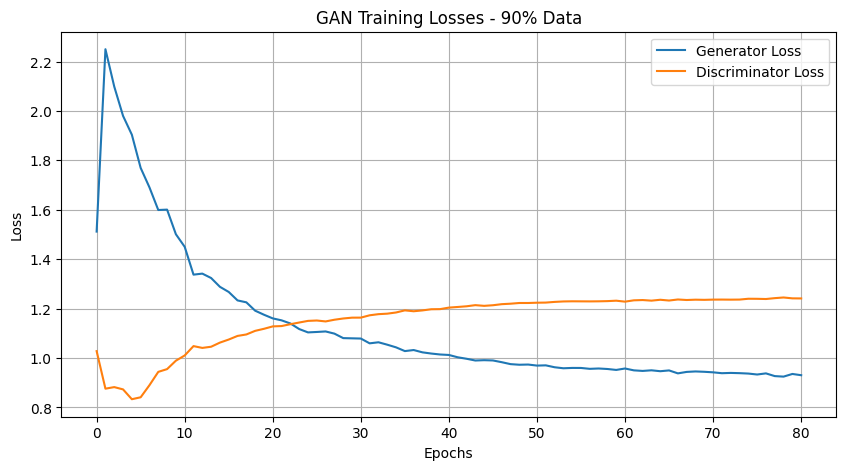

[Epoch 81/100] [Batch 0/421] [D loss: 1.2076] [G loss: 0.8918] [Time: 1838.18s]
[Epoch 81/100] [Batch 100/421] [D loss: 1.2132] [G loss: 0.9633] [Time: 1843.57s]
[Epoch 81/100] [Batch 200/421] [D loss: 1.2316] [G loss: 1.0322] [Time: 1849.02s]
[Epoch 81/100] [Batch 300/421] [D loss: 1.2639] [G loss: 0.9224] [Time: 1854.43s]
[Epoch 81/100] [Batch 400/421] [D loss: 1.2907] [G loss: 1.0817] [Time: 1859.75s]
[Epoch 81/100] [Avg D loss: 1.2427] [Avg G loss: 0.9268]
[Epoch 82/100] [Batch 0/421] [D loss: 1.2477] [G loss: 0.9076] [Time: 1860.89s]
[Epoch 82/100] [Batch 100/421] [D loss: 1.2447] [G loss: 0.8665] [Time: 1866.32s]
[Epoch 82/100] [Batch 200/421] [D loss: 1.2706] [G loss: 0.8663] [Time: 1871.69s]
[Epoch 82/100] [Batch 300/421] [D loss: 1.2641] [G loss: 1.0756] [Time: 1877.05s]
[Epoch 82/100] [Batch 400/421] [D loss: 1.2336] [G loss: 0.8435] [Time: 1882.39s]
[Epoch 82/100] [Avg D loss: 1.2447] [Avg G loss: 0.9275]
[Epoch 83/100] [Batch 0/421] [D loss: 1.3092] [G loss: 0.9900] [Time: 

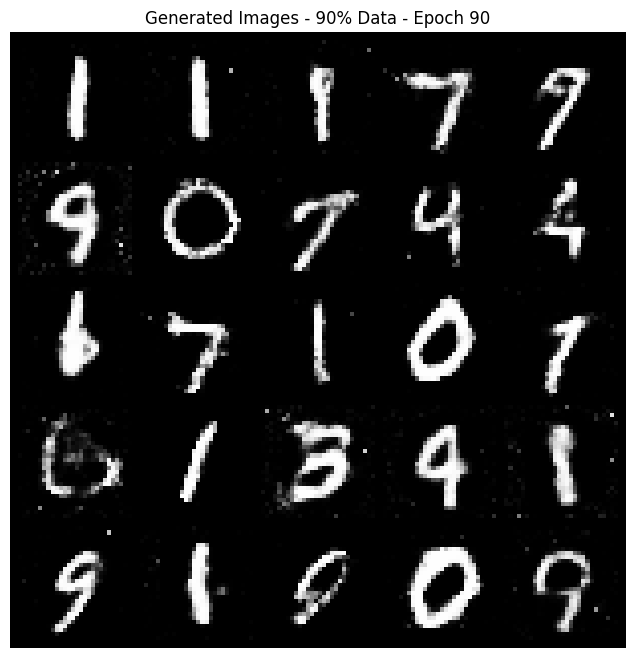

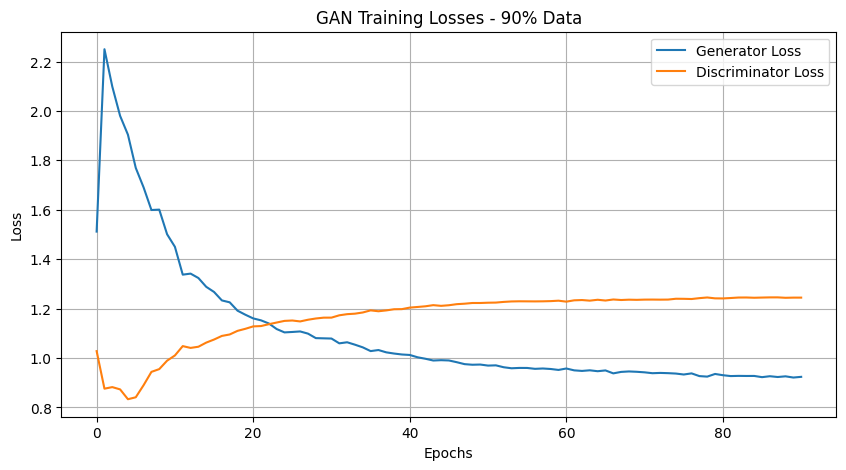

[Epoch 91/100] [Batch 0/421] [D loss: 1.2766] [G loss: 0.8075] [Time: 2065.04s]
[Epoch 91/100] [Batch 100/421] [D loss: 1.2628] [G loss: 0.9397] [Time: 2070.38s]
[Epoch 91/100] [Batch 200/421] [D loss: 1.2158] [G loss: 0.8841] [Time: 2075.75s]
[Epoch 91/100] [Batch 300/421] [D loss: 1.2185] [G loss: 0.9083] [Time: 2081.14s]
[Epoch 91/100] [Batch 400/421] [D loss: 1.2299] [G loss: 0.8732] [Time: 2086.57s]
[Epoch 91/100] [Avg D loss: 1.2447] [Avg G loss: 0.9269]
[Epoch 92/100] [Batch 0/421] [D loss: 1.2645] [G loss: 0.8631] [Time: 2087.70s]
[Epoch 92/100] [Batch 100/421] [D loss: 1.1967] [G loss: 0.9116] [Time: 2093.05s]
[Epoch 92/100] [Batch 200/421] [D loss: 1.2437] [G loss: 0.9710] [Time: 2098.42s]
[Epoch 92/100] [Batch 300/421] [D loss: 1.2310] [G loss: 1.0171] [Time: 2103.78s]
[Epoch 92/100] [Batch 400/421] [D loss: 1.2044] [G loss: 0.8666] [Time: 2109.15s]
[Epoch 92/100] [Avg D loss: 1.2453] [Avg G loss: 0.9206]
[Epoch 93/100] [Batch 0/421] [D loss: 1.2660] [G loss: 0.9663] [Time: 

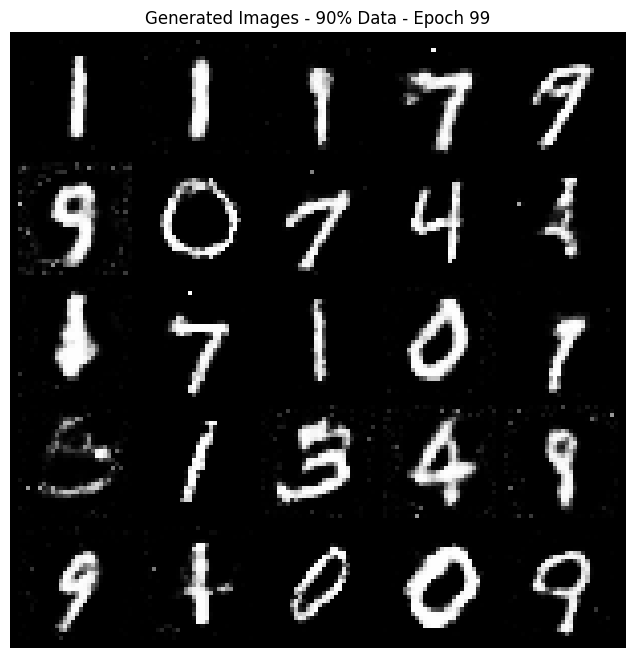

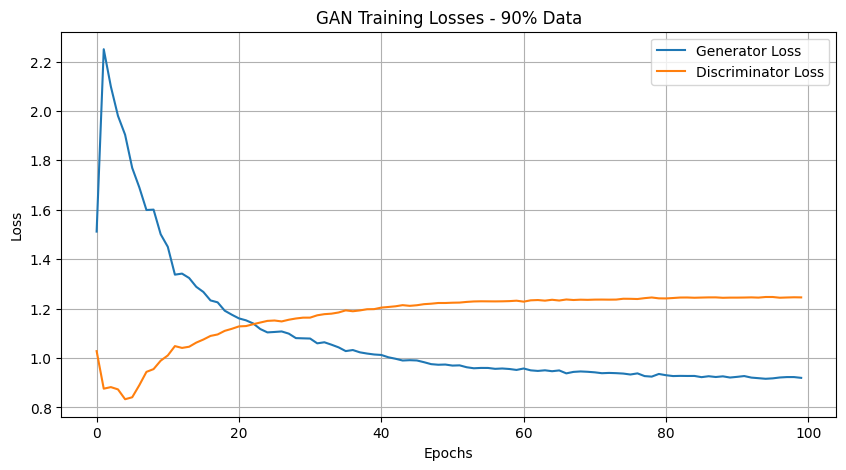

Training finished!
Total training time: 37.82 minutes
Models saved!


In [201]:
set_random_seed(42)

g_losses, d_losses = train_gan(subset_percentage)

### Results Analysis

Let's examine our final loss plot and generate some images with the trained model.

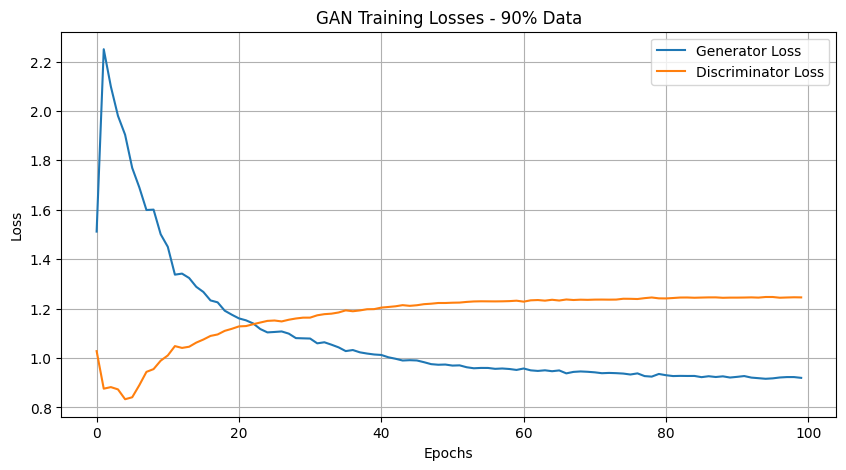

In [202]:
plot_losses(g_losses, d_losses, subset_percentage)

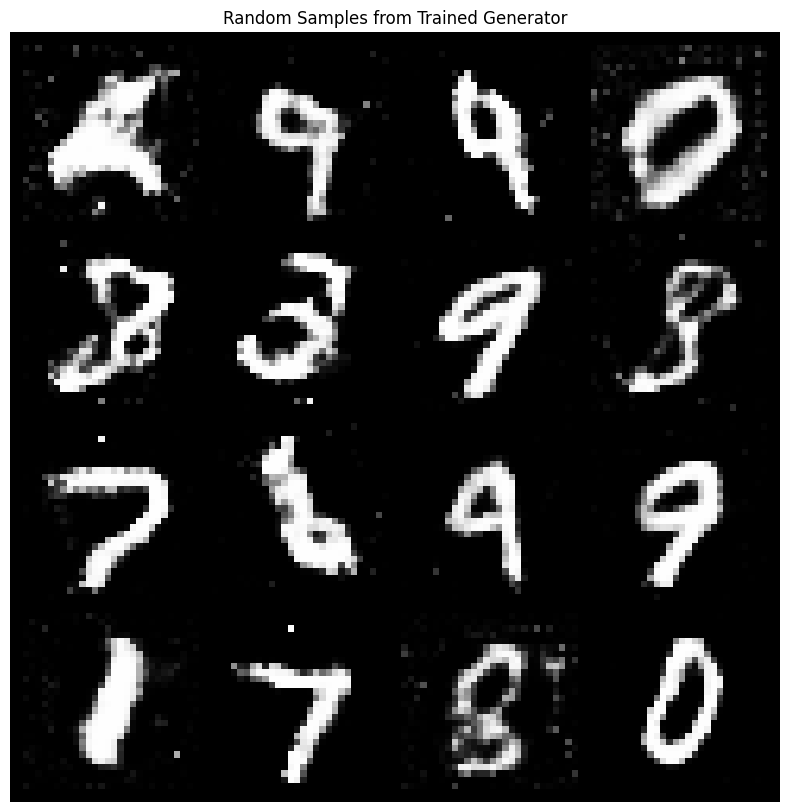

In [203]:
# Generate random samples after training
with torch.no_grad():
    # Generate random noise
    z = torch.randn(16, latent_dim).to(device)
    # Generate images
    samples = generator(z).detach().cpu()
    # Rescale images
    samples = 0.5 * samples + 0.5
    # Display images
    grid = make_grid(samples, nrow=4, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title("Random Samples from Trained Generator")
    plt.show()

## 8. Next Steps for Thesis Research

1. **Data Subset Selection Strategies**:
   - Random sampling (as baseline)
   - Figure out a way to get informed subsest of the data

2. **Evaluation Metrics**:
   - Frechet Inception Distance (FID)
   - Inception Score (IS)
   - Precision and Recall metrics
   - Training stability measures

3. **Experiments to Run**:
   - Train with different subset sizes (10%, 20%, 30%, etc.)
   - Compare different subset selection methods
   - Analyze what makes certain samples more "informative" for GANs
   - Test if informative samples transfer across different GAN architectures